In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

seed=1
rng = np.random.RandomState(seed)

%matplotlib inline

# Gaussian Process

Here I will try to have the notation not all mixed up, X\_ will be $X_*$ in notes, and in general \_ will mean $_*$

* $X_*$ is the points where we will sample from our distribution (GP)
* $X$ are the observed positions

## Plotting prior (sample all space)

Let's just sample from the distribution we just created

Create the ground truth function and variables we will need

In [2]:
# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()

N = 10         # number of training points.
n = 500        # number of test points.
s = 0.005      # noise variance.

let's create the kernel, which generally it is defined by

$$
 K(x_1,x_2) = \sigma^2_f \frac 1 {e^{\frac 1 {2l}(x_1-x_2)^2}}
$$

In [3]:
# Define the kernel function with pararmeter l
def kernel(a, b):
    """ GP squared exponential kernel """
    l = 1.0
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/l) * sqdist)

In [4]:
# Sample some input points and noisy versions of the function evaluated at
# these points. 
X_ = np.linspace(-5, 5, n).reshape(-1,1)

# Get the K matrix
K_ = kernel(X_,X_)

let's plot it

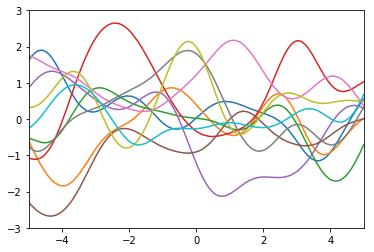

In [5]:
# draw samples from the prior at our test points.
L_ = np.linalg.cholesky(K_ + 1e-6*np.eye(n))  # 1e-6*np.eye(n) is to make it +ve and add some noise
f_prior = np.dot(L_, rng.normal(size=(n,10))) # Sampling from the covariance, remember the mean = 0
plt.figure(1)
plt.clf()
plt.plot(X_, f_prior)
plt.axis([-5, 5, -3, 3])
plt.savefig('prior.png', bbox_inches='tight')

## Adding measurred inputs

**Let's make some samples** and incorporate them into the model

Let's remember the mean is calculated as

$$
m = \mathbf k^{(*)T}M^{-1}\mathbf y
$$

let's just remember the GP posterior will be

$$
p(f|D) = \frac {p(D|f)p(f)}{p(D)}
$$

---

Here it is important to remember that given a joing probability

$$
p(\mathbf{f,g}) = \mathcal N \left(
\begin{bmatrix}
\mathbf f \\ \mathbf g
\end{bmatrix};
\begin{bmatrix}
\mathbf a \\ \mathbf b
\end{bmatrix},
\begin{bmatrix}
A & C\\
C^T & B
\end{bmatrix}
\right)
$$

then, given that any conditional distribution of a Gaussian distribution is a Gaussian too, we have

$$
p(f|g) = \mathcal N (\mathbf{f;a}+CB^{-1}(\mathbf{g-b}), A - CB^{-1}C^T)
$$

so we can use this formula to integrate a prior with mean different from zero 

---

and the mean is defined as

$$
\bar f_* = \mathbf k_*^T\mathbf K_y^{-1}y
$$

but

$$
\mathbf K_y^{-1}y = L^{-T}L^{-1}y
$$

therefore

$$
\bar f_* = \mathbf k_*^TL^{-T}L^{-1}y
$$

here Lk is

$$
\text{Lk} = L^{-1}\mathbf k_*^T
$$

In [6]:
X = rng.uniform(-5, 5, size=(N,1)) # Points were we will sample
y = f(X) + s*rng.randn(N)          # Measurements with some noise 

K = kernel(X, X)                         # Variance of the measured points
L = np.linalg.cholesky(K + s*np.eye(N))  # Cholesky decomposition for K

# points we're going to make predictions at.
# i.e. the discritized points
Xtest = np.linspace(-5, 5, n).reshape(-1,1) 

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest)) # Computing mean avoiding inverse of K (part1)
mu = np.dot(Lk.T, np.linalg.solve(L, y))  # Computing mean avoiding inverse of K (part2)

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)  # Computing variance
std= np.sqrt(s2)                          # Computing std

# Cholesky decomposition for the posterior
L_ = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk)) # Cholesky decomposition

# Sampling from mu and K
# This is is simplefied when K=LL^T
f_post = mu.reshape(-1,1) + np.dot(L_, rng.normal(size=(n,10)))

## Ploting results

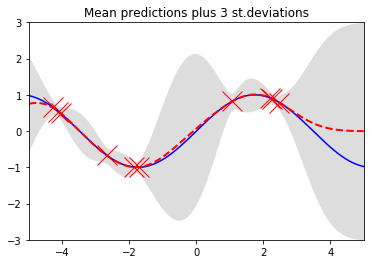

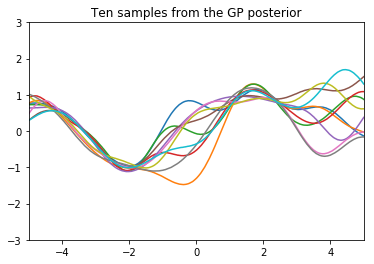

In [7]:
# PLOTS:
plt.figure(1)
plt.clf()
plt.plot(X, y, 'rx', ms=20)
plt.plot(Xtest, f(Xtest), 'b-')
plt.gca().fill_between(Xtest.flat, mu-3*std, mu+3*std, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.savefig('predictive.png', bbox_inches='tight')
plt.title('Mean predictions plus 3 st.deviations')
plt.axis([-5, 5, -3, 3])

# draw samples from the posterior at our test points.
plt.figure(3)
plt.clf()
plt.plot(Xtest, f_post)
plt.title('Ten samples from the GP posterior')
plt.axis([-5, 5, -3, 3])
plt.savefig('post.png', bbox_inches='tight')

plt.show()